In [2]:
import cv2
from forwardFv1 import wm_au_emb
import numpy as np
from matplotlib import pyplot as plt
from detectFv1 import *
from recoveryFv1 import stage1_recovery,stage2_recovery
from utilsFv1 import score_IOU


In [3]:
key = (13,137,811)
# image = cv2.imread("D:\\Dat_Hoctap\\2023\\Tamper_Recover\\A_Data\\png\\airplane.png")
image = cv2.imread("D:\\2023\\Tamper_Recover\\A_Data\\png\\airplane.png")
w_image = wm_au_emb(image,key)


In [4]:
# mask = cv2.imread("D:\\Dat_Hoctap\\2023\\Tamper_Recover\\A_Data_Tamper\\mask_airplane.png",0)
# masked = cv2.bitwise_and(w_image, w_image, mask=mask)
# mask = cv2.resize(mask,dsize=(512-128,512-128))
# masked = cv2.resize(masked,dsize=(512-128,512-128))
# mask_inv = cv2.bitwise_not(mask)
# img1_bg = cv2.bitwise_and(w_image[0:200,128:512],w_image[0:200,128:512],mask = mask_inv[50:250,:] )
# img2_object =  cv2.bitwise_and(masked[50:250,:,:] ,masked[50:250,:,:] ,mask = mask[50:250,:] )
# tamp_img = w_image.copy()
# tamp_img[0:200,128:512] = cv2.add(img1_bg,img2_object)

In [5]:
# mask = cv2.imread("D:\\Dat_Hoctap\\2023\\Tamper_Recover\\A_Data_Tamper\\mask_airplane.png",0)
mask = cv2.imread("D:\\2023\\Tamper_Recover\\A_Data_Tamper\\mask_airplane.png",0)
masked = cv2.bitwise_and(w_image, w_image, mask=mask)
mask_inv = cv2.bitwise_not(mask)
img1_bg = cv2.bitwise_and(w_image[300:500,:,:],w_image[300:500,:,:],mask = mask_inv[100:300,:] )
img2_object =  cv2.bitwise_and(masked[100:300,:,:] ,masked[100:300,:,:] ,mask = mask[100:300,:] )
tamp_img = w_image.copy()
tamp_img[300:500,:,:] = cv2.add(img1_bg,img2_object)

In [6]:
ground_truth = np.zeros_like(mask)
ground_truth[300:500,:] = mask[100:300,:]
ground_truth = (ground_truth/255).astype(bool)

In [7]:
len(np.where((mask/255).astype(bool)==True)[0])

34625

In [33]:
t_rate = len(np.where(mask==255)[0])*100/(512*512)

In [9]:
psnr_W = cv2.PSNR(w_image,image)

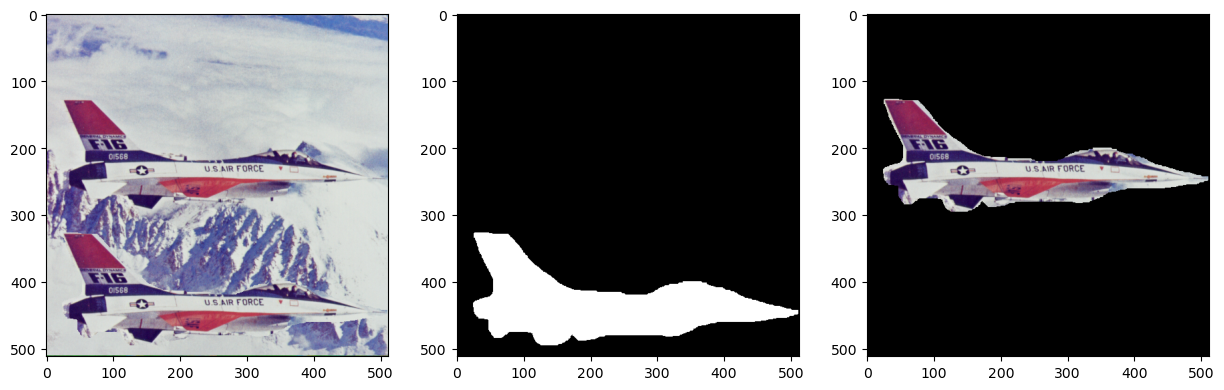

In [10]:
fig,axes =  plt.subplots(1, 3,figsize = (15,5))
axes[0].imshow(cv2.cvtColor(tamp_img,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray,vmax=255,vmin=0)
axes[1].imshow(ground_truth, cmap=plt.cm.gray,vmax=1,vmin=0)
axes[2].imshow(cv2.cvtColor(masked,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray,vmax=255,vmin=0)

In [11]:
lv1_matrix = level_one_detection(tamp_img)
lv2_matrix = lv1_matrix.copy()
lv3_matrix = lv1_matrix.copy()
for channel in range(3):
    lv2_matrix[:,:,channel] = level_two_detection(lv1_matrix[:,:,channel])
    lv3_matrix[:,:,channel] = level_three_detection(lv2_matrix[:,:,channel])
lv3_detection = lv3_matrix[:,:,0] & lv3_matrix[:,:,1] & lv3_matrix[:,:,2]
r1_img,lv4_BGR= stage1_recovery(t_img=tamp_img,key=key)
r2_img,lv5_BGR = stage2_recovery(r1_img=r1_img,lv4_matrix=lv4_BGR)

In [28]:
au_matrix = np.zeros_like(image,dtype=np.uint8)
for i in range(3):
    for r in range(lv3_matrix.shape[0]):
        for c in range(lv3_matrix.shape[1]):
            if not lv3_matrix[r,c,i]:
                au_matrix[2*r:2*r+2,2*c:2*c+2,i] = 1
au_matrix_overall = np.zeros_like(ground_truth,dtype=np.uint8)
for r in range(lv3_matrix.shape[0]):
    for c in range(lv3_matrix.shape[1]):
        if not lv3_detection[r,c]:
            au_matrix_overall[2*r:2*r+2,2*c:2*c+2] = 1


In [29]:
print(score_IOU(authen_matrix=au_matrix[:,:,2],ground_truth=ground_truth))
print(score_IOU(authen_matrix=au_matrix_overall,ground_truth=ground_truth))

0.9443787315534528
0.9670320451876293


In [30]:
score_iouB = score_IOU(authen_matrix=au_matrix[:,:,0],ground_truth=ground_truth)
score_iouG = score_IOU(authen_matrix=au_matrix[:,:,1],ground_truth=ground_truth)
score_iouR = score_IOU(authen_matrix=au_matrix[:,:,2],ground_truth=ground_truth)
score_iou_orall = score_IOU(authen_matrix=au_matrix_overall,ground_truth=ground_truth)

In [12]:
lv3_detection = lv3_matrix[:,:,0] & lv3_matrix[:,:,1] & lv3_matrix[:,:,2]
psnr_R1 = cv2.PSNR(r1_img,image)
psnr_R2 = cv2.PSNR(r2_img,image)

In [13]:
mask1 = np.zeros((512,512),dtype = np.uint8)
for i in range(512):
    for j in range(512):
        if not lv5_BGR[int(i/1),int(j/1),0]:
            mask1[i,j] = 255
mask2 = np.zeros((512,512),dtype = np.uint8)
for i in range(512):
    for j in range(512):
        if not lv5_BGR[int(i/1),int(j/1),1]:
            mask2[i,j] = 255
mask3 = np.zeros((512,512),dtype = np.uint8)
for i in range(512):
    for j in range(512):
        if not lv5_BGR[int(i/1),int(j/1),2]:
            mask3[i,j] = 255

In [14]:
r3_img = tamp_img.copy()
r3_img[:,:,0] = cv2.inpaint(r2_img[:,:,0],mask1,1,cv2.INPAINT_TELEA)
r3_img[:,:,1] = cv2.inpaint(r2_img[:,:,1],mask2,1,cv2.INPAINT_TELEA)
r3_img[:,:,2] = cv2.inpaint(r2_img[:,:,2],mask3,1,cv2.INPAINT_TELEA)
psnr_R3 = cv2.PSNR(r3_img,image)

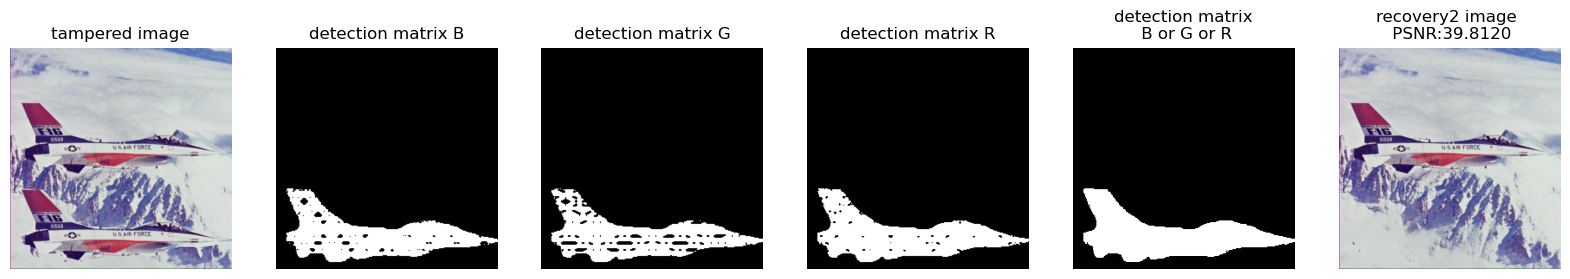

In [21]:
fig, axes = plt.subplots(1, 6,figsize = (20,10))
axes[0].set_axis_off()
axes[1].set_axis_off()
axes[2].set_axis_off()
axes[3].set_axis_off()
axes[4].set_axis_off()
axes[5].set_axis_off()

axes[0].set_title(f'tampered image')
axes[1].set_title(f'detection matrix B')
axes[2].set_title(f'detection matrix G')
axes[3].set_title(f'detection matrix R')
axes[4].set_title(f'detection matrix\n B or G or R')
axes[5].set_title(f'recovery2 image \n PSNR:{cv2.PSNR(r3_img,image):.4f}')

axes[0].imshow(cv2.cvtColor(tamp_img,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray,vmax=255,vmin=0)
axes[1].imshow(au_matrix[:,:,0], cmap=plt.cm.gray,vmax=1,vmin=0)
axes[2].imshow(au_matrix[:,:,1], cmap=plt.cm.gray,vmax=1,vmin=0)
axes[3].imshow(au_matrix[:,:,2], cmap=plt.cm.gray,vmax=1,vmin=0)
axes[4].imshow(1-lv3_detection, cmap=plt.cm.gray,vmax=1,vmin=0)
axes[5].imshow(cv2.cvtColor(r3_img,cv2.COLOR_BGR2RGB), cmap=plt.cm.gray,vmax=255,vmin=0)

In [39]:
List_title = ["Host Image",f"Watermarked Image\n PSNR: {psnr_W:.4f}",f"Tampered Image\n Tamper rate:{t_rate:.2f}%",
              f"Recovered Image Stage2\n w/o inpainting PSNR: {psnr_R2:.4f}",f"Recovered Image Stage3\n w inpainting PSNR:{psnr_R3:.4f}",
              "Authentication\n Ground truth",f"Authentication B channel \n IOU:{score_iouB:.4f}",f"Authentication G Channel \n IOU:{score_iouG:.4f}",
              f"Authentication R Channel \n IOU:{score_iouR:.4f}",f"Authentication B or G or R \n IOU:{score_iou_orall:.4f}"]
List_image = [image,w_image,tamp_img,r2_img,r3_img,ground_truth,au_matrix[:,:,0],au_matrix[:,:,1],au_matrix[:,:,2],au_matrix_overall]

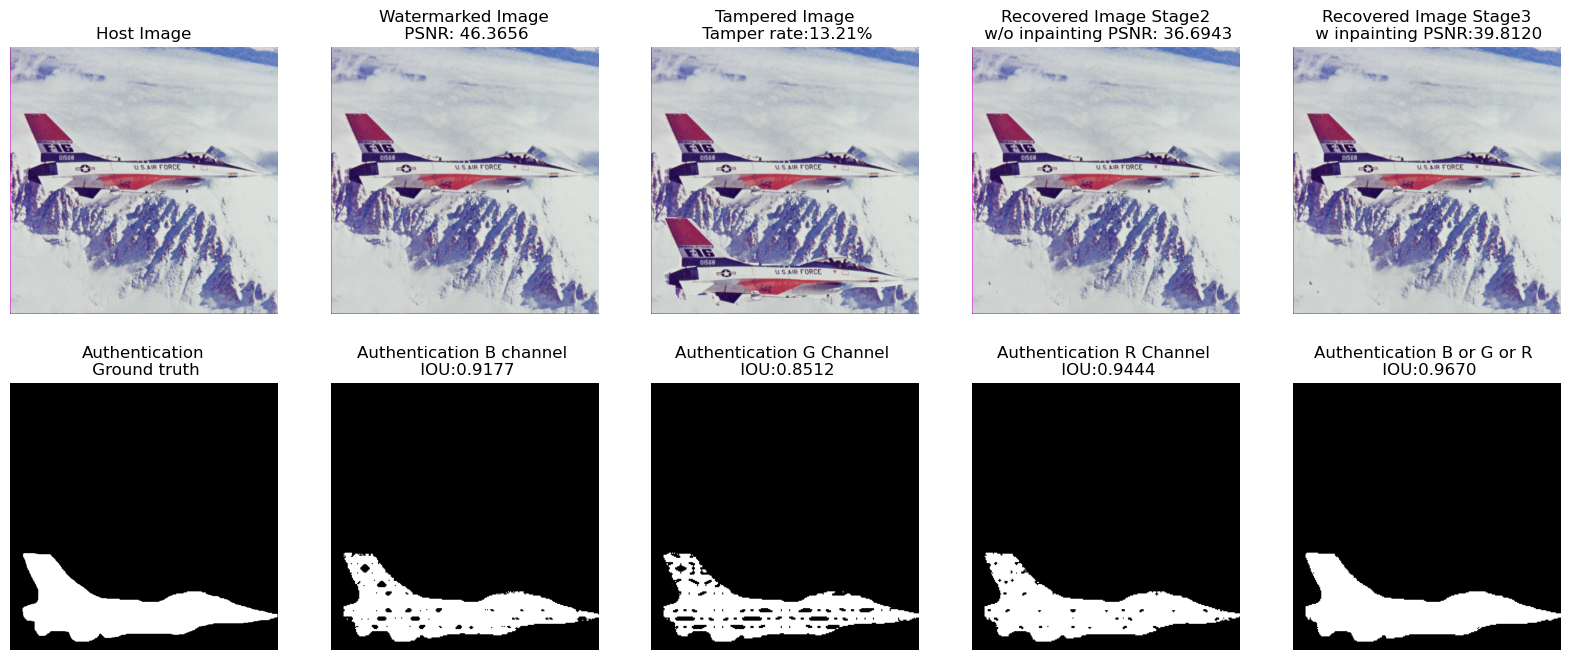

In [47]:
fig, axes = plt.subplots(2, 5,figsize = (20,8))
for i in range(2):
    for j in range(5):
        axes[i,j].set_axis_off()
        axes[i,j].set_title(List_title[i*5+j])
for j in range(5):
    axes[0,j].imshow(cv2.cvtColor(List_image[j],cv2.COLOR_BGR2RGB), cmap=plt.cm.gray,vmax=255,vmin=0)            
    axes[1,j].imshow(List_image[5+j], cmap=plt.cm.gray,vmax=1,vmin=0)
fig.savefig("results/result_cp_attack.png")

